# Coursework 1 - Artificial Intelligence and Machine Learning
# Student Name: Archana Shrirang Dhage
# Student Email: adhage301@caledonian.ac.uk

I confirm that the material contained within the submitted coursework is all my own work unless otherwise stated below.

---


# Introduction
This assessment aims to create machine learning models to predict the monthly rental price of residential properties in London using the dataset rent_ads_rightmove_extended.csv, a modified version of the “London Property Rental Dataset” (Kaggle). The dataset includes 3,076 listings, each with attributes covering  **location** (address, subdistrict code), **property details** (bedrooms, bathrooms, property type, size), **tenancy information** (furnishing status, let type, council tax, deposit), and **transport accessibility** (average distance to the nearest station, nearby station count), and the **target feature** rent. These features are key drivers of rental prices in London’s dynamic housing market, where demand, supply, and location-based pricing heavily influence monthly rent values.

### Why is this a Regression Problem?

This is a **regression problem** because the target variable, monthly rent in GBP, is a continuous numeric value. Regression models predict continuous values (e.g., £900), unlike classification models that predict categories (e.g., "low”, “high" rent). Here, the aim is not to categorize properties but to estimate a specific monetary value based on multiple input features.

### Problem Statement

**Can machine learning accurately predict the monthly rental price of a London property based on attributes such as location, size, furnishing, and proximity to transport?**

Accurate predictions can assist:

- **Tenants**, in budgeting and assessing fairness of rental listings.
- **Landlords and property agents**, in setting competitive and realistic rental prices.
- **Policy makers and analysts**, in understanding housing affordability trends.

This project will involve building a regression pipeline that handles data cleaning, feature engineering, model training, performance evaluation and compares different machine learning models to solve rent prediction problem effectively.


## Load libraries

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Ingestion

In [ ]:
# Loading the dataset
df = pd.read_csv("/content/rent_ads_rightmove_extended.csv")

# Displaying the first few rows
df.head()

,address,subdistrict_code,rent,deposit,Let type,Furnish Type,Coucil Tax,PROPERTY TYPE,BEDROOMS,BATHROOMS,SIZE,avg_distance_to_nearest_station,nearest_station_count
0,"Morse Close, Harefield, UB9",UB9,1200,1384,Long term,Unfurnished,Ask agent,Apartment,1.0,1.0,Ask agent,2.1,3
1,"Dolphin Square, London, SW1V",SW1V,1983,2288,Long term,"Furnished or unfurnished, landlord is flexible",Ask agent,Apartment,1.0,1.0,335 sq ft,0.4,3
2,"Warlters Road, Holloway, London, N7",N7,1800,0,Long term,Unfurnished,Ask agent,Apartment,1.0,1.0,Ask agent,0.5,3
3,"Rockingham Road, Uxbridge",NaN,1650,1903,Long term,Unfurnished,Ask agent,Apartment,2.0,1.0,Ask agent,1.6,3
4,"Northwick Avenue, Harrow, HA3",HA3,2700,3115,Long term,Unfurnished,Ask agent,End of Terrace,3.0,2.0,Ask agent,0.4,3


In [ ]:
df.shape

(3076, 13)

## Overview of the Data

The dataset includes features such as

- Address: Categorical (Nominal). Full property address.
- Subdistrict Code: Categorical (Nominal). Area or postcode label.
- Rent (Target): Numerical (Continuous). Monthly rent in GBP.
- Deposit: Numerical (Continuous). Security deposit amount.
- Let Type: Categorical (Nominal). Rental type, short or long let.
- Furnish Type: Categorical (Nominal). Furnished, unfurnished, part-furnished, or flexible.
- Council Tax: Categorical (Nominal). Often missing, marked as “Ask agent.”
- Property Type: Categorical (Nominal). House, flat, apartment, etc.
- Bedrooms: Numerical (Discrete). Number of bedrooms.
- Bathrooms: Numerical (Discrete). Number of bathrooms; may have missing values.
- Size: Numerical (Continuous). Property area in square feet; many values missing.
- Average Distance to Nearest Station: Numerical (Continuous).  Distance to the nearest station in miles.
- Nearest Station Count: Numerical (Discrete). Count of nearby stations within a radius


In [ ]:
# Summary of dataset
df.info()

# Describe numerical fields
df.describe(include=[np.number])

# Describe categorical fields
df.describe(include=[object])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   address                          3076 non-null   object 
 1   subdistrict_code                 1662 non-null   object 
 2   rent                             3076 non-null   int64  
 3   deposit                          3076 non-null   int64  
 4   Let type                         2848 non-null   object 
 5   Furnish Type                     3076 non-null   object 
 6   Coucil Tax                       3076 non-null   object 
 7   PROPERTY TYPE                    3076 non-null   object 
 8   BEDROOMS                         3076 non-null   float64
 9   BATHROOMS                        2866 non-null   float64
 10  SIZE                             3076 non-null   object 
 11  avg_distance_to_nearest_station  3076 non-null   float64
 12  nearest_station_coun

,address,subdistrict_code,Let type,Furnish Type,Coucil Tax,PROPERTY TYPE,SIZE
count,3076,1662,2848,3076,3076,3076,3076
unique,2575,209,2,5,3,25,493
top,"Lexham Gardens, London, W8",E14,Long term,Furnished,Ask agent,Flat,Ask agent
freq,18,171,2751,1794,3055,1201,2257


In [ ]:
df.isna().sum()

,0
address,0
subdistrict_code,1414
rent,0
deposit,0
Let type,228
Furnish Type,0
Coucil Tax,0
PROPERTY TYPE,0
BEDROOMS,0
BATHROOMS,210


# Data Preparation

## Handling Missing Values in `Furnish Type`




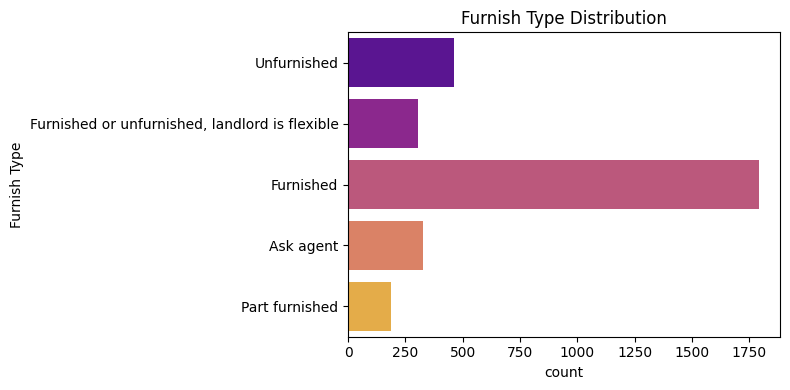

In [ ]:
# Categorical: Furnish Type
plt.figure(figsize=(8, 4))
sns.countplot(y='Furnish Type', data=df, palette='plasma')
plt.title('Furnish Type Distribution')
plt.tight_layout()
plt.show()

The bar chart above shows that "Ask agent" is used as a placeholder, not a valid category

To clean this column:
- Replaced `"Ask agent"` with NaN.
- Filled missing values with the **mode** (most common furnishing type), a reasonable default when details are unknown..

This allows to retain the column for modeling while avoiding bias from non-informative placeholder values.

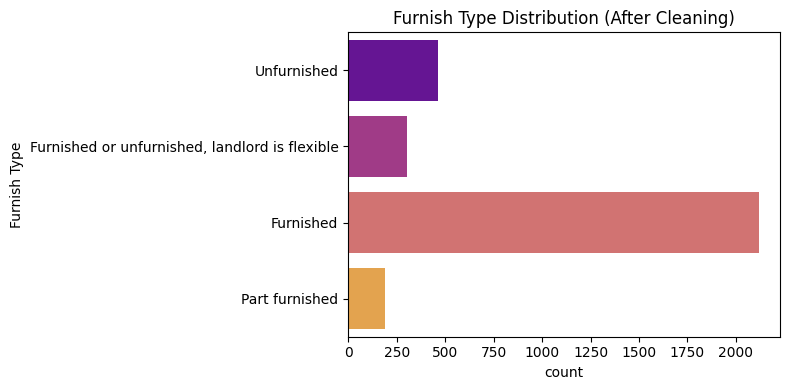

In [ ]:
# Replace 'Ask agent' with NaN
df['Furnish Type'] = df['Furnish Type'].replace("Ask agent", np.nan)

# Impute missing values with the mode
furnish_mode = df['Furnish Type'].mode()[0]
df['Furnish Type'].fillna(furnish_mode, inplace=True)

# Confirm the change
plt.figure(figsize=(8, 4))
sns.countplot(y='Furnish Type', data=df, palette='plasma')
plt.title('Furnish Type Distribution (After Cleaning)')
plt.tight_layout()
plt.show()

## Cleaning and Outlier Handling of `SIZE` Feature

The `SIZE` column contains inconsistencies such as:
- Placeholder text ("Ask agent")
- Numeric values with commas, inconsistent spacing or a range (e.g., “525-530 sq ft”)

To prepare this feature:
1. Extracted numeric values using regular expressions.
2. Visualized the raw size distribution to identify anomalies.
3. Used the Interquartile Range (IQR) method to detect and remove outliers.
4. Re-plotted the cleaned distribution to confirm consistency.

This process ensures the `SIZE` feature is numeric, consistent, and free of anomalies that could bias the regression model.Missing values were imputed in a later step.


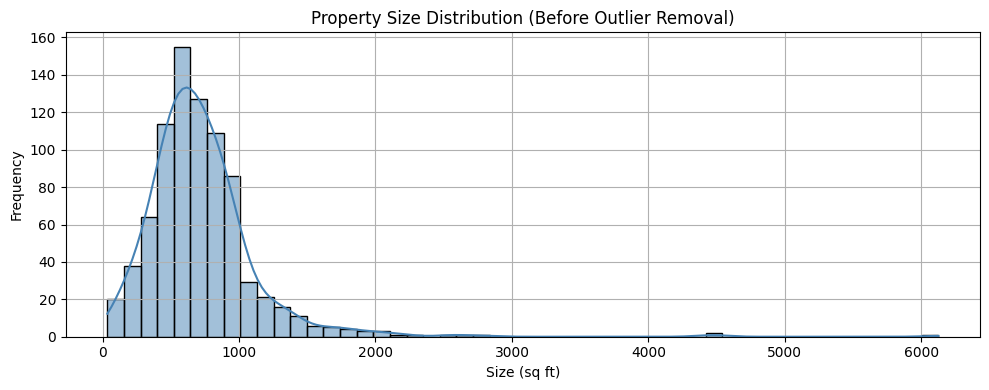

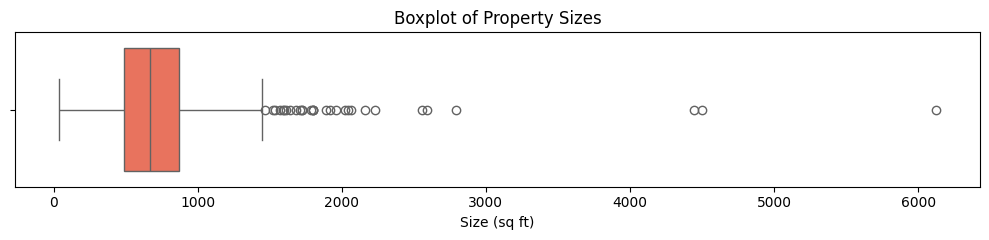


Original entries: 3076, After removing outliers: 3046



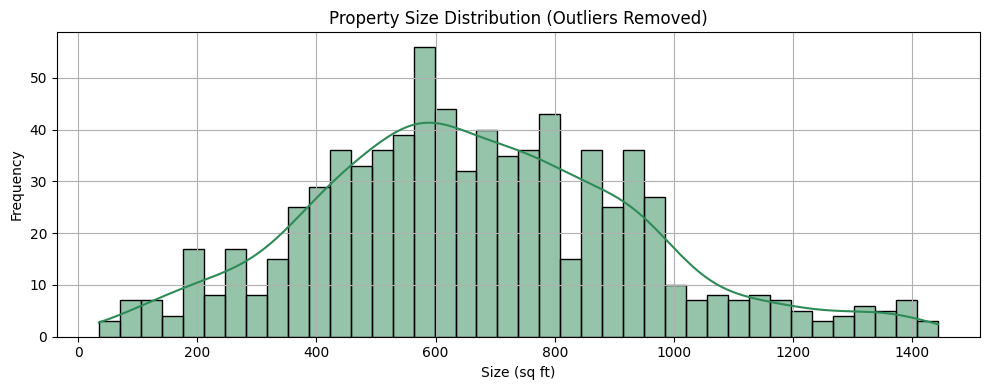

In [ ]:
# Replacing the "Ask agent" with NaN
df['SIZE'] = df['SIZE'].replace('Ask agent', np.nan)
# Removing commas and extra spaces
df['SIZE_cleaned'] = df['SIZE'].str.replace(',', '', regex=False).str.strip()
# Handle range values like "250-300" by taking the average
df['SIZE_cleaned'] = df['SIZE_cleaned'].str.replace(
    r'(\d+)\s*-\s*(\d+)',
    lambda m: str((int(m.group(1)) + int(m.group(2))) / 2),
    regex=True
)
# Removing leading zeros (but keeping valid decimals like 0.5)
df['SIZE_cleaned'] = df['SIZE_cleaned'].str.replace(r'\b0+(\d)', r'\1', regex=True)
# Extracting the numeric value
df['SIZE_numeric'] = df['SIZE_cleaned'].str.extract(r'(\d+\.?\d*)').astype(float)

# Initial histogram before outlier removal
plt.figure(figsize=(10, 4))
sns.histplot(df['SIZE_numeric'], bins=50, kde=True, color='steelblue')
plt.title('Property Size Distribution (Before Outlier Removal)')
plt.xlabel('Size (sq ft)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot to visualize outliers
plt.figure(figsize=(10, 2.5))
sns.boxplot(x=df['SIZE_numeric'], color='tomato')
plt.title('Boxplot of Property Sizes')
plt.xlabel('Size (sq ft)')
plt.tight_layout()
plt.show()

# Detecting outliers using IQR method
Q1 = df['SIZE_numeric'].quantile(0.25)
Q3 = df['SIZE_numeric'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag and filter out outliers
df['SIZE_outlier_flag'] = ((df['SIZE_numeric'] < lower_bound) | (df['SIZE_numeric'] > upper_bound))
df_cleaned = df[~df['SIZE_outlier_flag']].copy()

print(f"\nOriginal entries: {len(df)}, After removing outliers: {len(df_cleaned)}\n")

# Final histogram after removing outliers
plt.figure(figsize=(10, 4))
sns.histplot(df_cleaned['SIZE_numeric'], bins=40, kde=True, color='seagreen')
plt.title('Property Size Distribution (Outliers Removed)')
plt.xlabel('Size (sq ft)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Replace original column and drop helpers if desired
df['SIZE'] = df_cleaned['SIZE_numeric']
df.drop(['SIZE_cleaned', 'SIZE_numeric', 'SIZE_outlier_flag'], axis=1, inplace=True)


## Extracting data from the `Address` Column

The `address` column consists of useful but inconsistent location information, some with full street, area, city, and postcode, others with only partial information. To make use of it, a custom parser was used.

By splitting the address from right to left, the following were extracted:
- **Postcode** (usually last)
- **City** (second-to-last)
- **Area** (before city)

Many rows were missing subdistrict_code, but some had the postcode in the address. The extracted postcode was used to fill in missing subdistrict_code values.

**Extracting Area** allows grouping properties by location, which is then used to impute missing `SIZE` values.


In [ ]:
import pandas as pd
import re

def balanced_address_parser(address):
    address = str(address).strip()
    postcode = None
    city = 'London'  # Fixed as London for all entries
    area = None

    # Extract postcode using regex (UK postcode format)
    postcode_match = re.search(r"\b([A-Z]{1,2}\d{1,2}[A-Z]?)\b", address.upper())
    if postcode_match:
        postcode = postcode_match.group(1)
        postcode_index = address.upper().rfind(postcode)
        pre_postcode = address[:postcode_index].strip()
    else:
        pre_postcode = address

    # Split address on commas
    parts = [p.strip() for p in pre_postcode.split(',') if p.strip()]

    # Remove 'London' if it's a part (so we don't treat it as area)
    parts = [p for p in parts if p.lower() != 'london']

    # Set area as the last remaining part (if any)
    if parts:
        area = parts[-1]

    # Remove 'London' if it is still inside the area string
    if area:
        area = area.replace('London', '').strip(', ').strip()
        if area == '':
            area = None

    return pd.Series([area, city, postcode])

In [ ]:
df[['area', 'city', 'postcode']] = df['address'].apply(balanced_address_parser)
df['subdistrict_code'] = df['subdistrict_code'].fillna(df['postcode'])
df[['address', 'area', 'city', 'postcode', 'subdistrict_code']].head(15)

,address,area,city,postcode,subdistrict_code
0,"Morse Close, Harefield, UB9",Harefield,London,UB9,UB9
1,"Dolphin Square, London, SW1V",Dolphin Square,London,SW1V,SW1V
2,"Warlters Road, Holloway, London, N7",Holloway,London,N7,N7
3,"Rockingham Road, Uxbridge",Uxbridge,London,None,None
4,"Northwick Avenue, Harrow, HA3",Harrow,London,HA3,HA3
5,"Fitzroy Street, London, W1T",Fitzroy Street,London,W1T,W1T
6,"Watermans Quay, London, SW6",Watermans Quay,London,SW6,SW6
7,Talbot Square,Talbot Square,London,None,None
8,Phoenix Court Gasholder Place SE11,Phoenix Court Gasholder Place,London,SE11,SE11
9,"Barandon Walk, London, W11",Barandon Walk,London,W11,W11


## Imputing Missing Values in the `SIZE` Column

The `SIZE` column is important for understanding property value, but many entries had missing values. A structured, two-step approach was applied:

1. The average bedroom size was calculated by grouping data by `area` and `PROPERTY TYPE`.
2. Missing `SIZE` values were estimated by multiplying bedroom count by the average bedroom size for similar properties in the same area.
3. If that information was unavailable, the fallback used the average size for the same `PROPERTY TYPE`  across the dataset.




In [ ]:
print('The number of null values before imputation in the "SIZE" column is: ' ,df['SIZE'].isna().sum() )

The number of null values before imputation in the "SIZE" column is:  2287


In [ ]:
# Step 1: Calculate average bedroom size for city + property_type combinations
df_valid_size = df[df['SIZE'].notna() & df['BEDROOMS'].notna() & (df['BEDROOMS'] > 0)].copy()
df_valid_size['avg_bedroom_size'] = df_valid_size['SIZE'] / df_valid_size['BEDROOMS']


# Group averages
bedroom_size_lookup = df_valid_size.groupby(['area', 'PROPERTY TYPE'])['avg_bedroom_size'].mean()

# Step 2: Function to estimate SIZE for missing entries
def estimate_size(row):
    if pd.notna(row['SIZE']):
        return row['SIZE']
    try:
        avg_bedroom_size = bedroom_size_lookup.loc[(row['area'], row['PROPERTY TYPE'])]
        if pd.notna(row['BEDROOMS']) and row['BEDROOMS'] > 0:
            return avg_bedroom_size * row['BEDROOMS']
    except:
        pass
    # Fallback: mean SIZE by PROPERTY TYPE
    type_avg = df_valid_size.groupby('PROPERTY TYPE')['SIZE'].mean()
    return type_avg.get(row['PROPERTY TYPE'], np.nan)


# Step 3: Apply to full dataset

df['SIZE_filled'] = df.apply(estimate_size, axis=1)
df['SIZE'] = df['SIZE_filled']


In [ ]:
print('The number of null values after the imputation in the "SIZE" column is: ' , df['SIZE_filled'].isna().sum() )

The number of null values after the imputation in the "SIZE" column is:  81


In [ ]:
df = df.drop('SIZE_filled', axis=1)

## Final Missing Data Handling

After cleaning, remaining missing values were addressed as follows:

- **Let type**: Since most listings are for long-term rentals, missing entries were filled with the most frequent value using simple mode-based imputation.
  
- **Bathrooms**: For entries missing bathroom counts, a 1:1 ratio between bedrooms and bathrooms was assumed, a common real estate convention, especially in urban listings.
  
- **SIZE**: After hybrid estimation, remaining missing values were filled with median property size to avoid outlier bias.


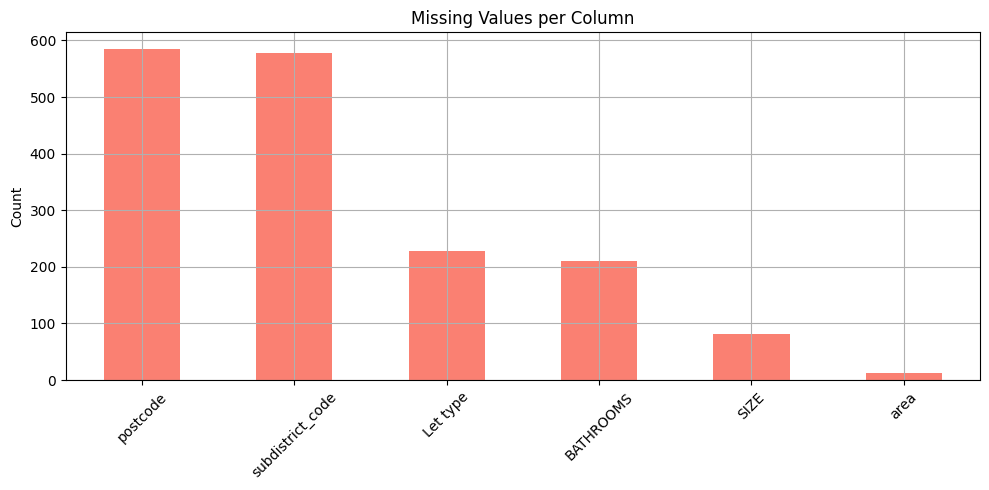

In [ ]:
# Visualize missing values before handling
plt.figure(figsize=(10, 5))
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts.sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title("Missing Values per Column")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Dropping unnecessary columns
**postcode, subdistrict_code** features were removed due to a large number of missing values.

**council Tax** column was removed since mostly its entries were "Ask agent" which provided no value to the model.

**address** column was eliminated due to its poor predictive value, with encoding increasing complexity but not improving performance.



In [ ]:
# Fill missing Let type with the most common value (mode)
df['Let type'].fillna(df['Let type'].mode()[0], inplace=True)
# Fill missing bathrooms with number of bedrooms (assuming at least 1 bathroom per bedroom)
df['BATHROOMS'] = df['BATHROOMS'].fillna(df['BEDROOMS'])
# Fill remaining missing size_filled with median
df['SIZE'] = df['SIZE'].fillna(df['SIZE'].median())

df = df.drop(['postcode','subdistrict_code', 'Coucil Tax','address','city'],axis = 1) # Also dropping city because it has same data 'London'


## Data Binning Justification
Data binning was not used because continuous variables like `SIZE`, `avg_distance_to_nearest_station`, and `deposit` provide more detailed information in their original form. binning may cause loss of detail and reduce the model’s ability to detect small and significant differences.
Models like Random Forest handle continuous variables well, so retaining the full numeric detail improved model accuracy.


## Feature Engineering

To enhance model performance and capture meaningful patterns, following features were engineered:

- **Rent per Bedroom**: Eases the comparison of rental rates across differently sized properties by providing the cost per room.
- **Rent per Square Foot**: Especially important in high-demand areas.
- **Bedroom-to-Bathroom Ratio**: Helps assess the spatial balance of a property’s layout.

In [ ]:
# Avoid division by zero or NaN
df['rent_per_bedroom'] = df.apply(
    lambda row: row['rent'] / row['BEDROOMS'] if row['BEDROOMS'] and row['BEDROOMS'] > 0 else np.nan,
    axis=1
)

In [ ]:
df['rent_per_sqft'] = df.apply(
    lambda row: row['rent'] / row['SIZE'] if row['SIZE'] and row['SIZE'] > 0 else np.nan,
    axis=1
)

In [ ]:
df['bed_bath_ratio'] = df.apply(
    lambda row: row['BEDROOMS'] / row['BATHROOMS'] if row['BATHROOMS'] and row['BATHROOMS'] > 0 else np.nan,
    axis=1
)

In [ ]:
df.head()

,rent,deposit,Let type,Furnish Type,PROPERTY TYPE,BEDROOMS,BATHROOMS,SIZE,avg_distance_to_nearest_station,nearest_station_count,area,rent_per_bedroom,rent_per_sqft,bed_bath_ratio
0,1200,1384,Long term,Unfurnished,Apartment,1.0,1.0,710.328358,2.1,3,Harefield,1200.0,1.689360,1.0
1,1983,2288,Long term,"Furnished or unfurnished, landlord is flexible",Apartment,1.0,1.0,335.000000,0.4,3,Dolphin Square,1983.0,5.919403,1.0
2,1800,0,Long term,Unfurnished,Apartment,1.0,1.0,710.328358,0.5,3,Holloway,1800.0,2.534039,1.0
3,1650,1903,Long term,Unfurnished,Apartment,2.0,1.0,710.328358,1.6,3,Uxbridge,825.0,2.322869,2.0
4,2700,3115,Long term,Unfurnished,End of Terrace,3.0,2.0,849.000000,0.4,3,Harrow,900.0,3.180212,1.5


## Feature Encoding and Scaling

Before modeling, transforming the features altogether:

1. **Numerical features**:  
- Apply **standard scaling** to center and normalize variance.
2. **Categorical features**:  
- One-Hot Encoding changed categories into binary columns, which prevent any bias and support both tree-based and linear models.

This ensures a single fully numeric matrix ready for train/test splitting.


In [ ]:

import pandas as pd
import numpy as np

# Step 1: Identify column types
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['rent']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Step 2: Scale numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Step 3: Apply One-Hot Encoding to categorical columns (instead of Label Encoding)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)



# Data Segregation
To evaluate a model’s effectiveness in learning, it is important to assess its performance on unseen data. Therefore, the training and test dataset split of 80:20 was selected. This is a common practice for datasets of this size to strike a balance between model performance and providing a fair measure of learning. For consistency across different model iterations, a fixed random seed (random_state=42) was applied.



In [ ]:
X = df.drop(columns=['rent'])
y = df['rent']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

## Model Selection and Justification

1. **Linear Regression**  
   A simple, interpretable model assuming a straight-line between the input features and the target variable (monthly rent). It is used as a **baseline** to compare with more advanced models.

2. **Random Forest Regressor**  
   An ensemble of decision trees that captures  **non-linear patterns**, **reduces overfitting**, and handles both numeric and categorical data well, ideal for complex rental dataset.

3. **XGBoost Regressor**  
   A fast and regularized gradient boosting model that handles **non-linearities**, is **robust to outliers**, and often delivers **top performance** in regression tasks.


### Why Use Baseline (Default) Parameters?

Starting with default setting gives a performance baseline, helps to:
- Understand how well models perform without tuning
- Measure improvement from hyperparameter tuning





In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

baseline_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    baseline_results[name] = {
        'RMSE': float(round(np.sqrt(mean_squared_error(y_test, preds)), 4)),
        'MAE': float(round(mean_absolute_error(y_test, preds), 4)),
        'R2': float(round(r2_score(y_test, preds), 4))
    }

baseline_results

{'Linear Regression': {'RMSE': 1096.6812, 'MAE': 636.3265, 'R2': 0.7376},
 'Random Forest': {'RMSE': 322.6756, 'MAE': 59.0334, 'R2': 0.9773},
 'XGBoost': {'RMSE': 289.0211, 'MAE': 96.7135, 'R2': 0.9818}}

## Hyperparameter Tuning
**GridSearchCV** was used to increase model performance and reduce overfitting. It analyzes several hyperparameter combinations and chooses the optimum configuration based on RMSE, which prioritizes reducing big rent prediction mistakes.

- **Random Forest** tuned `n_estimators` and `max_depth` to balance learning and reduce overfitting.
- **XGBoost** tuned `n_estimators`, `max_depth`, and `learning_rate` for better generalization and accuracy.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Random Forest grid
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators':[100,200], 'max_depth':[10,20]}
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='neg_root_mean_squared_error')
grid_rf.fit(X_train, y_train)

# XGBoost grid
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {'n_estimators':[100,200], 'max_depth':[3,6], 'learning_rate':[0.1,0.2]}
grid_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_root_mean_squared_error')
grid_xgb.fit(X_train, y_train)

grid_rf.best_params_, grid_xgb.best_params_


({'max_depth': 20, 'n_estimators': 200},
 {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200})

# Model Evaluation


## Evaluation Metrics

- **RMSE** (Root Mean Squared Error): Highlights large errors, which is important for rent predictions because big mistakes can be costly.
- **MAE** (Mean Absolute Error): Shows average error is easier to interpret and less sensitive to outliers.
- **R² Score**: Indicates the proportion of rent variation the model explains, higher values indicate better fit.



In [ ]:
opt_results = {}

# Random Forest tuned
rf_best = grid_rf.best_estimator_
pred_rf = rf_best.predict(X_test)
opt_results['Random Forest (Tuned)'] = {
    'RMSE': float(round(np.sqrt(mean_squared_error(y_test, pred_rf)), 4)),
    'MAE': float(round(mean_absolute_error(y_test, pred_rf), 4)),
    'R2': float(round(r2_score(y_test, pred_rf), 4))
}

# XGBoost tuned
xgb_best = grid_xgb.best_estimator_
pred_xgb = xgb_best.predict(X_test)
opt_results['XGBoost (Tuned)'] = {
    'RMSE': float(round(np.sqrt(mean_squared_error(y_test, pred_xgb)), 4)),
    'MAE': float(round(mean_absolute_error(y_test, pred_xgb), 4)),
    'R2': float(round(r2_score(y_test, pred_xgb), 4))
}

opt_results



{'Random Forest (Tuned)': {'RMSE': 275.9501, 'MAE': 57.6991, 'R2': 0.9834},
 'XGBoost (Tuned)': {'RMSE': 323.5693, 'MAE': 106.6645, 'R2': 0.9772}}

## Baseline vs Optimized Comparison

| Model                 | RMSE     | MAE    | R² Score |
| --------------------- | -------- | ------ | -------- |
| Linear Regression     | 1,096.68 | 636.33 | 0.7376   |
| Random Forest (Base)  | 322.68   | 59.03  | 0.9773   |
| XGBoost (Base)        | 289.02   | 96.71  | 0.9818   |
| Random Forest (Tuned) | 275.95   | 57.70  | 0.9834   |
| XGBoost (Tuned)       | 323.57   | 106.66 | 0.9772   |




## Evaluation Summary
•	The models were initially trained using default parameters to establish a baseline for assessing the impact of adjustment. Random Forest and XGBoost   substantially performed better than the linear model(R² = 0.7376, RMSE=1,096.68), indicating that ensemble approaches are better suited to this task.

•	The optimization of hyperparameters proved effective, as for Random Forest it increased R² to 0.9834 and reduced RMSE down to 275.95.

•	In contrast, XGBoost's performance dropped slightly (R² = 0.9772), after tuning, indicating that chosen tuned hyperparameters weren't ideal for XGBoost or may have resulted in overfitting.






The visual comparison helps highlight the gains achieved through model selection and tuning.

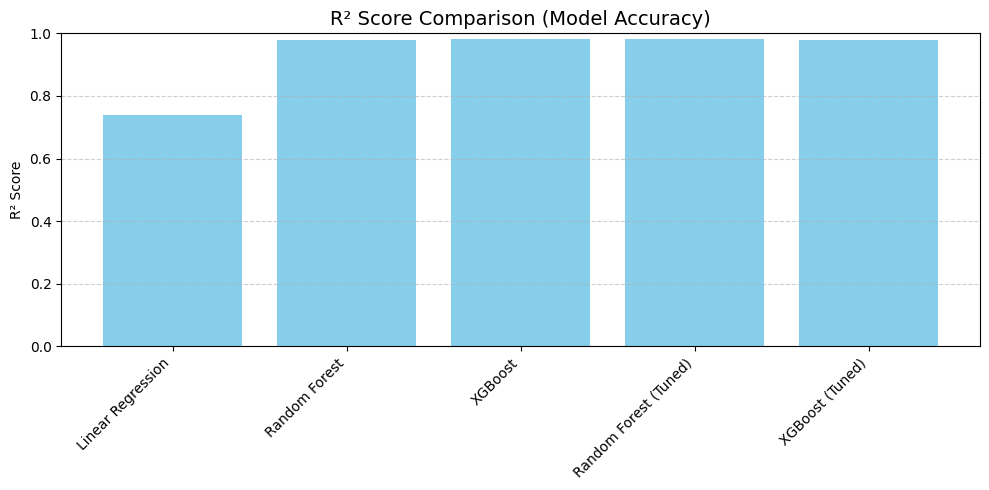

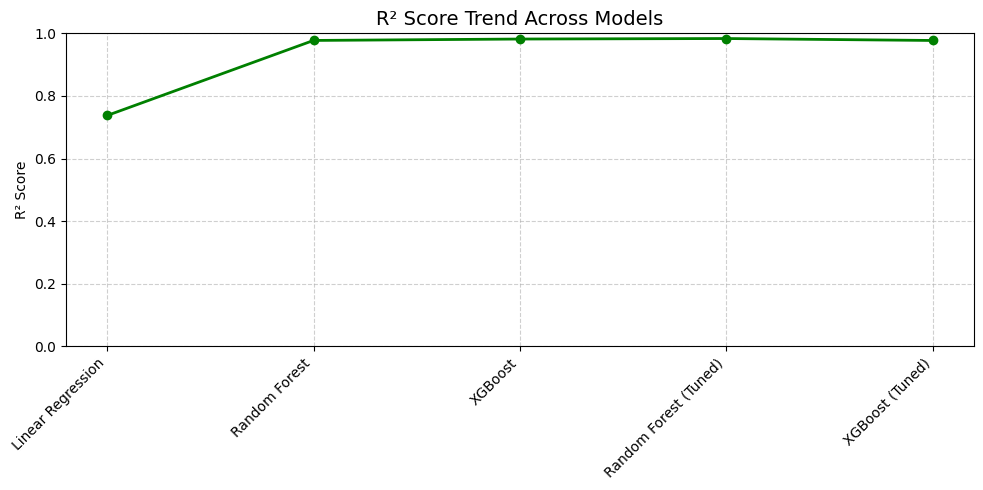

In [ ]:
import matplotlib.pyplot as plt

# Combine baseline and optimized results
all_results = {**baseline_results, **opt_results}

# Extract R2 scores, rmse,mae
model_names = list(all_results.keys())
r2_scores = [all_results[model]['R2'] for model in model_names]
rmse_scores = [all_results[model]['RMSE'] for model in model_names]
mae_scores = [all_results[model]['MAE'] for model in model_names]

# Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(model_names, r2_scores, color='skyblue')
plt.title("R² Score Comparison (Model Accuracy)", fontsize=14)
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Line Chart
plt.figure(figsize=(10, 5))
plt.plot(model_names, r2_scores, marker='o', color='green', linewidth=2)
plt.title("R² Score Trend Across Models", fontsize=14)
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


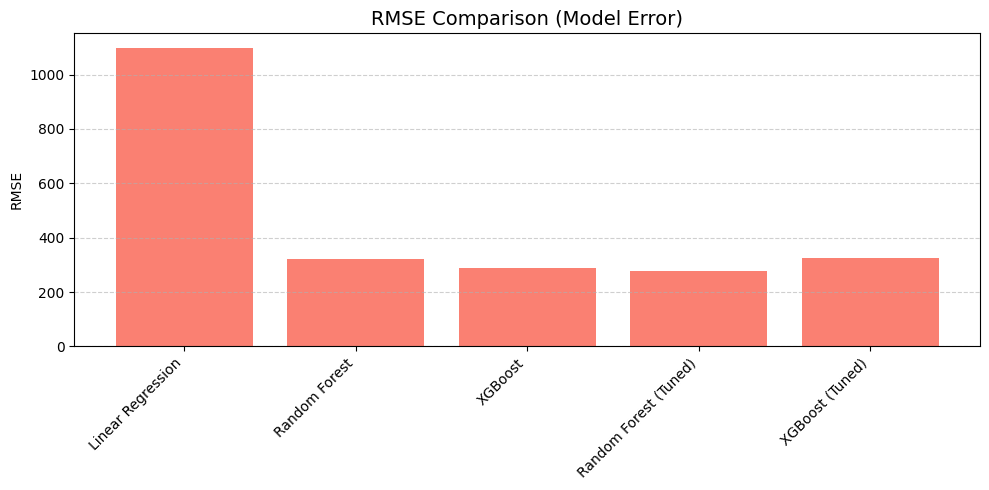

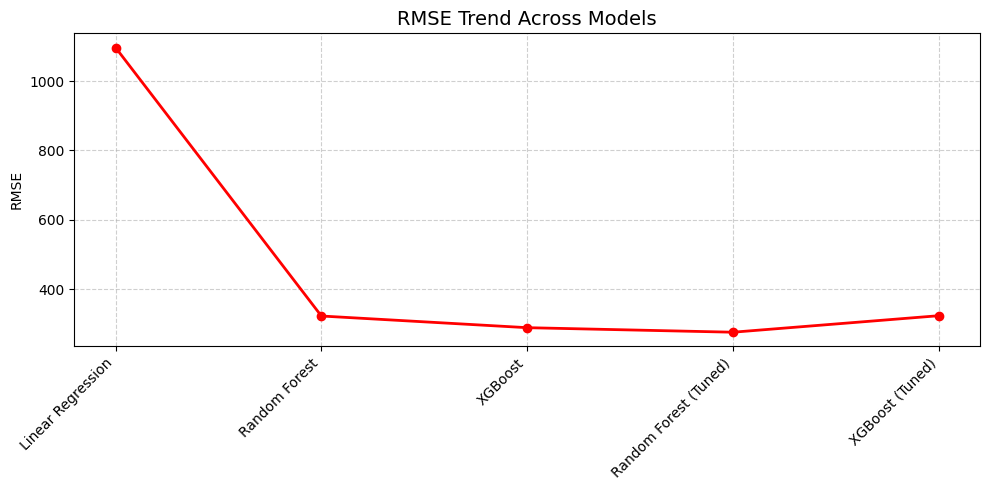

In [ ]:
# --- RMSE ---
plt.figure(figsize=(10, 5))
plt.bar(model_names, rmse_scores, color='salmon')
plt.title("RMSE Comparison (Model Error)", fontsize=14)
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(model_names, rmse_scores, marker='o', color='red', linewidth=2)
plt.title("RMSE Trend Across Models", fontsize=14)
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

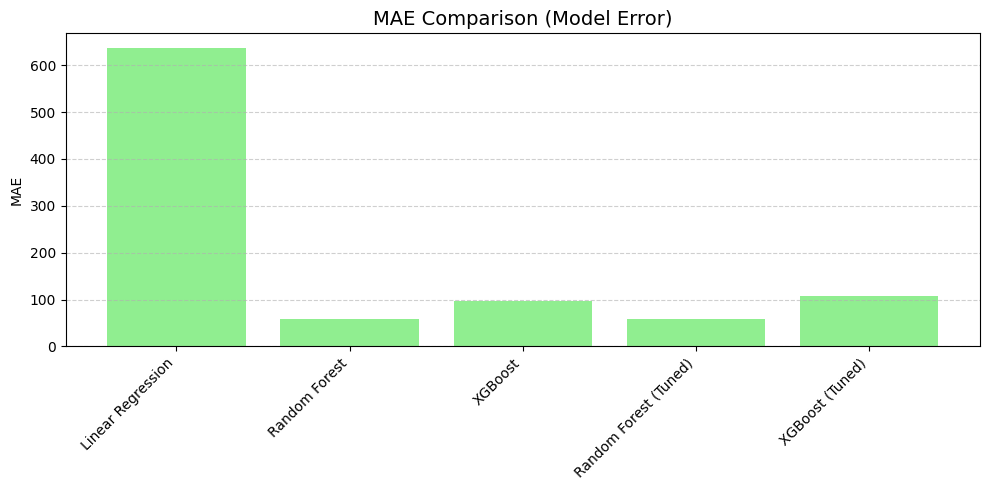

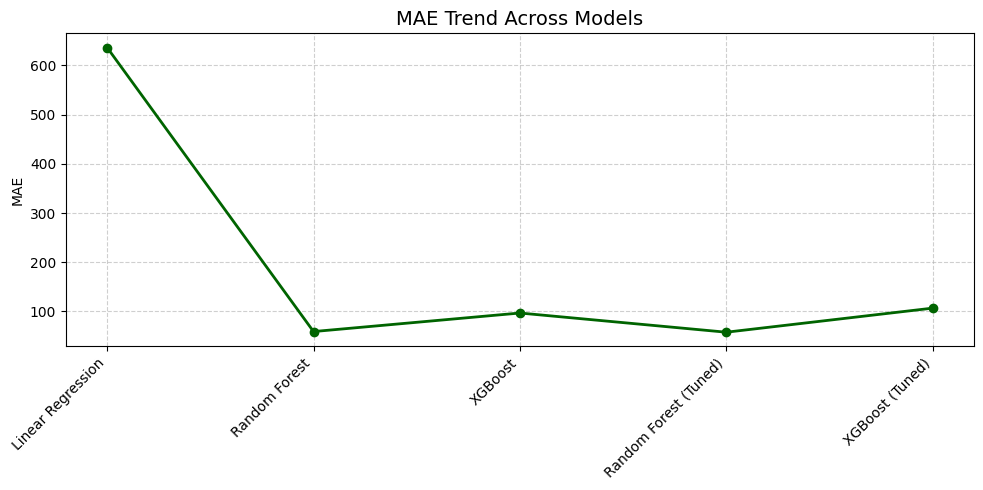

In [ ]:
# --- MAE ---
plt.figure(figsize=(10, 5))
plt.bar(model_names, mae_scores, color='lightgreen')
plt.title("MAE Comparison (Model Error)", fontsize=14)
plt.ylabel("MAE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(model_names, mae_scores, marker='o', color='darkgreen', linewidth=2)
plt.title("MAE Trend Across Models", fontsize=14)
plt.ylabel("MAE")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Discussion and Conclusion

This project highlights the importance of careful data management and model selection in making reliable forecasts.
Early data analysis showed missing values and mismatched formats, which were resolved through cleaning, contextual imputation, and the removal of irrelevant columns. This made the dataset much clearer and more reliable

Feature engineering like rent-per-square-foot, bedroom-to-bathroom ratios, and suitable encoding and scaling helped model to identify meaningful patterns in the dataset. The 80/20 train-test split ensured that the model was tested on a variety of property types, so it could perform well on new data.

The evaluation measures RMSE, MAE, and R² gave valuable insights about model's performance and accuracy. Ensemble models outperformed Linear Regression, however tuning improved performance of Random Forest, but XGBoost’s performance slightly dropped(R² = 0.9772), showing that more complex models do not always guarantee better results.


### Potential Improvements

1. **External Data**: Add transport, crime, schools, or amenities to provide more context  
2. **Geospatial Encoding**: Use latitude and longitude to model spatial patterns  
3. **Advanced Models**: Explore LightGBM, CatBoost, or stacked ensembles methods for better performance
4. **Temporal Modeling**: Use rent trends if listing dates are available to illustrate market dynamics.  


In summary, this project is a good start for predicting rental prices using given dataset and well-known modeling techniques, while also showing ways to improve and make the predictions more realistic in the future.


## Sources

- Understanding linear regression and its assumptions: https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares  
- Random Forest algorithm and parameters: https://scikit-learn.org/stable/modules/ensemble.html#random-forests  
- XGBoost documentation and parameter tuning: https://xgboost.readthedocs.io/en/stable/  
- GridSearchCV usage and explanation: https://scikit-learn.org/stable/modules/grid_search.html  
- Evaluation metrics for regression (RMSE, MAE, R²): https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics  
- Encoding categorical features: https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features  
- Handling missing values with pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html  
- Feature scaling and normalization: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler  
- R² score interpretation: https://en.wikipedia.org/wiki/Coefficient_of_determination  
- Stacking and ensemble learning: https://scikit-learn.org/stable/modules/ensemble.html#stacking  
- Working with scikit-learn pipelines: https://scikit-learn.org/stable/modules/compose.html  
- London Property Rental Dataset, https://www.kaggle.com/datasets/psgpyc/london-property-rental
